# Прогнозирование оттока клиентов в сети фитнес-центров

### Оглавление

1. [Описание проекта](#projekt) 
2. [Цель и задачи проекта](#purpose)     
3. [Описание данных](#data)    
4. [Открытие данных и изучение общей информации](#start)
5. [Подготовка данных](#preparation)   
6. [Исследовательский анализ данных](#analysis)
7. [Модель прогнозирования оттока клиентов](#model)   
8. [Кластеризация клиентов](#clustering)  
8. [Общий вывод](#conclusion)
9. [Рекомендации](#recommendations)

### Описание проекта
<a name="projekt"></a>

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

### Цель и задачи проекта
<a name="purpose"></a>

Цель проекта - провести анализ оттока клиентов и подготовить план действий по их удержанию.    
<br>Для этого необходимо:     
1. спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;   
2. сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;   
3. проанализировать основные признаки, наиболее сильно влияющие на отток;   
4. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:   
  * выделить целевые группы клиентов;  
  * предложить меры по снижению оттока;  
  * определить другие особенности взаимодействия с клиентами.

### Описание данных
<a name="data"></a>

- Churn - факт оттока в текущем месяце;  
- данные клиента за предыдущий до проверки факта оттока месяц:    
    - gender - пол;  
    - Near_Location - проживание или работа в районе, где находится фитнес-центр;  
    - Partner - сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент - в таком случае фитнес-центр хранит информацию о работодателе клиента);   
    - Promo_friends - факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
    - Phone - наличие контактного телефона;  
    - Age - возраст;  
    - Lifetime - время с момента первого обращения в фитнес-центр (в месяцах);
- информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:  
    - Contract_period - длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);  
    - Month_to_end_contract - срок до окончания текущего действующего абонемента (в месяцах);   
    - Group_visits - факт посещения групповых занятий;   
    - Avg_class_frequency_total - средняя частота посещений в неделю за все время с начала действия абонемента;  
    - Avg_class_frequency_current_month - средняя частота посещений в неделю за предыдущий месяц;  
    - Avg_additional_charges_total - суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

### Открытие данных и изучение общей информации
<a name="start"></a>

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline         
plt.rcParams.update({'font.size': 14})
import matplotlib
matplotlib.style.use('seaborn-darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,\
                            precision_score,\
                            recall_score,\
                            f1_score,\
                            roc_auc_score,\
                            silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}

In [3]:
# прочитаем DataFrame
try:
    df = pd.read_csv('gym_churn.csv')  # локальный путь
except:
    df = pd.read_csv('/datasets/gym_churn.csv')  # путь на сервере

In [4]:
# выведем на экран таблицу 10 верхних строк таблицы
df.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [5]:
# посмотрим размер таблицы
df.shape

(4000, 14)

Имеется исходная информация о данных клиента за предыдущий до проверки факта оттока месяц, информация на основе журналов посещений и покупок, а также информация о текущем статусе абонемента клиента.  
Данные представлены в виде таблицы, содержащей 4 000 строк и 14 столбцов, в которых указаны пол клиента, факт его проживания или работы в районе фитнес-центра, указание о принадлежности к компании-партнеру клуба, факт первоначальной записи о клиенте в рамках акции «приведи друга», наличие контактного телефона, возраст, время в месяцах с момента первого обращения в фитнес-центр, длительность текущего действующего абонемента, срок в месяцах до окончания текущего действующего абонемента, факт посещения групповых занятий, средняя частота посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, суммарная выручка от других услуг фитнес-центра, факт оттока в текущем месяце.

In [6]:
# посмотрим сводную информацию таблицы
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Тип данных у 10 столбцов целочисленный, у 4 - вещественный. Названия столбцов необходимо привести к нижнему регистру. В столбце `Month_to_end_contract` значения срока до окончания текущего действующего абонемента необходимо привести к целочисленному формату. 

In [7]:
# определим количество пропущенных значений в таблице
df.isnull().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Пропущенные значения отсутствуют.

In [8]:
# посчитаем количество дубликатов
df.duplicated().sum()

0

Дубликаты отсутствуют.

### Вывод

1. Имеется исходная информация о данных клиента за предыдущий до проверки факта оттока месяц, информация на основе журналов посещений и покупок, а также информация о текущем статусе абонемента клиента.  
2. Данные представлены в виде таблицы, содержащей 4 000 строк и 14 столбцов, пропущенные значения и дубликаты отсутствуют.  
3. В таблице указаны пол клиента, факт его проживания или работы в районе фитнес-центра, указание о принадлежности к компании-партнеру клуба, факт первоначальной записи о клиенте в рамках акции «приведи друга», наличие контактного телефона, возраст, время в месяцах с момента первого обращения в фитнес-центр, длительность текущего действующего абонемента, срок в месяцах до окончания текущего действующего абонемента, факт посещения групповых занятий, средняя частота посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, средняя суммарная выручка от других услуг фитнес-центра, факт оттока в текущем месяце.  
4. Тип данных у 10 столбцов целочисленный, у 4 - вещественный.  

В целях подготовки данных необходимо:   
1. названия столбцов привести к нижнему регистру;  
2. в столбце `Month_to_end_contract` значения срока до окончания текущего действующего абонемента привести к целочисленному формату.

### Подготовка данных
<a name="preparation"></a>

In [9]:
# приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [10]:
# приведем столбец со значениями срока до окончания текущего действующего абонемента к целочисленному формату
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')
df.dtypes

gender                                 int64
near_location                          int64
partner                                int64
promo_friends                          int64
phone                                  int64
contract_period                        int64
group_visits                           int64
age                                    int64
avg_additional_charges_total         float64
month_to_end_contract                  int64
lifetime                               int64
avg_class_frequency_total            float64
avg_class_frequency_current_month    float64
churn                                  int64
dtype: object

### Вывод

В целях подготовки данных:  
1. названия столбцов привели к нижнему регистру;  
2. в столбце `Month_to_end_contract` значения срока до окончания текущего действующего абонемента привели к целочисленному формату.

### Исследовательский анализ данных
<a name="analysis"></a>

In [11]:
# посмотрим на статистическую информацию по столбцам таблицы
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


В имеющейся информации среди клиентов:  
- мужчин и женщин примерно равное количество;  
- почти 85% проживают или работают в районе нахождения фитнес-центра;  
- почти половина являются сотрудниками компании-партнёра клуба;  
- около 30% использовали промо-код от знакомых при оплате первого абонемента;  
- более 90% указали контактный телефон;  
- около 40% посещали групповые занятия.  

Средний возраст клиентов - около 29 лет, среднее время с момента их первого обращения в фитнес-центр - 3,7 месяцев, средняя длительность текущего действующего абонемента - 4,7 месяцев (в то же время у более половины клиентов длительность действующего абонемента всего 1 месяц), средний срок до окончания текущего действующего абонемента - 4,3 месяца.     
В среднем каждый клиент за все время с начала действия абонемента посещал фитнес-центр около 1,9 раз в неделю, а за предыдущий месяц - около 1,8 раз в неделю. В среднем каждый клиент израсходовал на другие услуги фитнес-центра около 147 рублей.  
Отток клиентов в текущем месяце составил 26,5%.

In [12]:
# посмотрим на средние значения признаков по группам оставшихся и ушедших клиентов
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Группы оставшихся и ушедших клиентов не оличаются только по полу и наличию контактного телефона. По остальным признакам средние показатели у оставшихся клиентов выше, чем у ушедших, по некоторым значительно. Так, например, доля клиентов, использовавших промо-код от знакомых при оплате первого абонемента, а также посещавших групповые занятия, в 2 раза больше у оставшихся клиентов, чем у ушедших. Длительность текущего действующего абонемента у оставшихся клиентов в 3 раза выше, а время с момента первого обращения в фитнес-центр почти в 5 раз (ушедшие клиенты в среднем пользуются фитнес-центром меньше 1 месяца). Кроме того, у ушедших клиентов меньшая средняя частота посещений фитнес-центра, они меньше расходуют деньги на другие услуги. Средний возраст у ушедших клиентов по сравнению с оставшимися ниже на 3 года. 

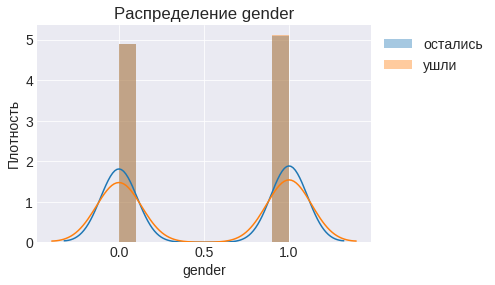

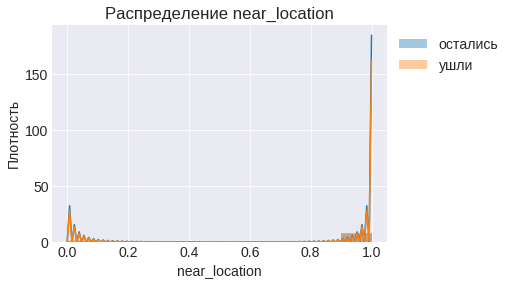

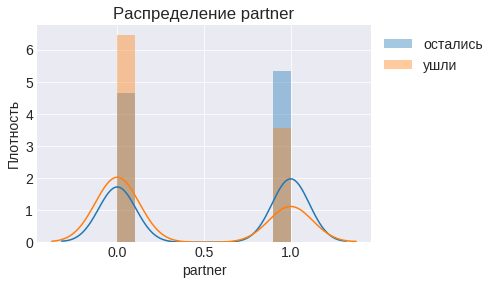

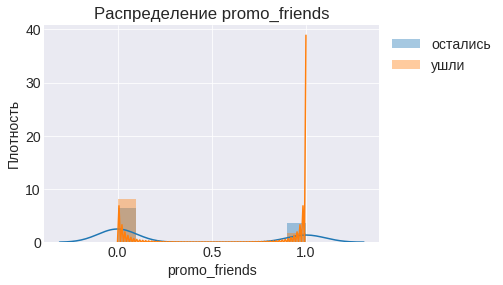

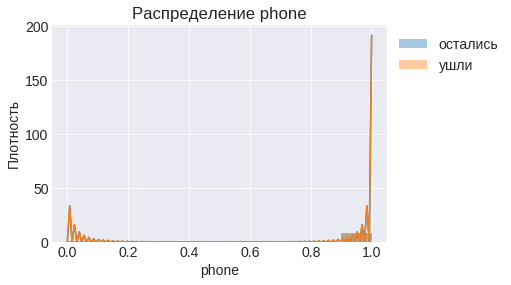

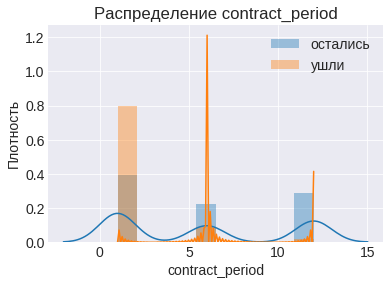

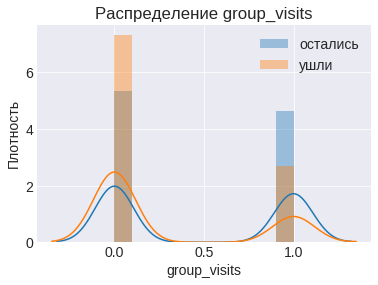

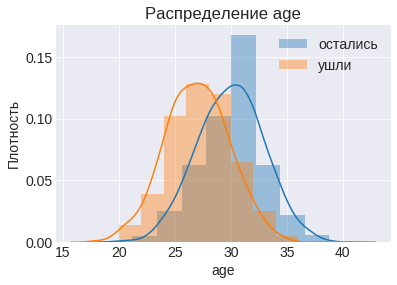

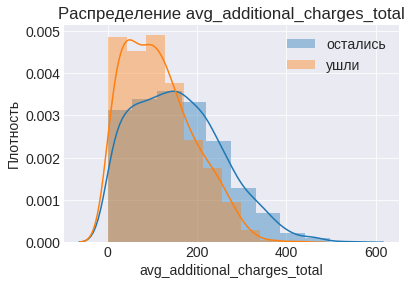

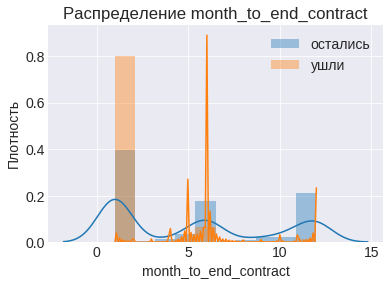

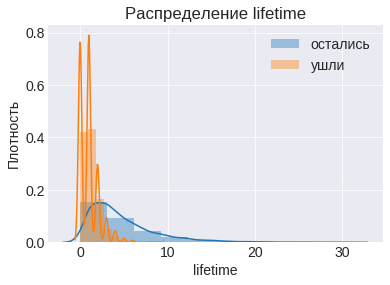

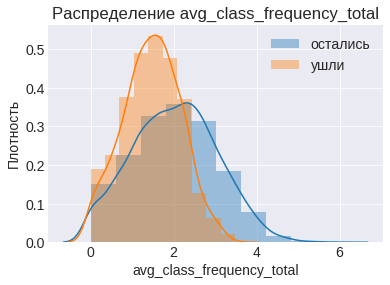

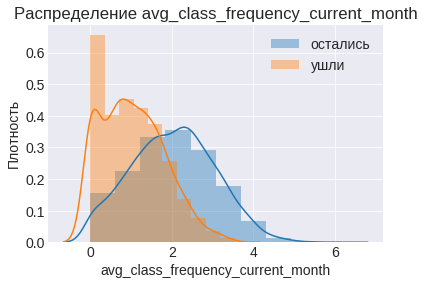

In [13]:
# построим столбчатые гистограммы и распределения признаков по группам оставшихся и ушедших клиентов
fig, ax = plt.subplots()
for column in df.drop(['churn'], axis = 1).columns:
    plt.title('Распределение ' + column)
    sns.distplot(df.query('churn == 0')[column],
                 bins = 10,
                 label = 'остались')
    sns.distplot(df.query('churn == 1')[column],
                 bins = 10,
                 label = 'ушли')
    plt.xlabel(column)
    plt.ylabel('Плотность')
    plt.legend(bbox_to_anchor = (1, 1))
    plt.show()

Исходя из построенных графиков, распределения возраста, времени в месяцах с момента первого обращения в фитнес-центр, средней частоты посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, средней суммарной выручки от других услуг фитнес-центра скошены вправо (имеются выбросы). Следовательно, перед построением модели необходимо выбросы обработать.

Примем за порог, при котором наблюдение считается выбросом, 95-й перцентиль. Значения, его превышающие, заменим на значения, соответствующие 95-му перцентилю.

In [14]:
# посчитаем 95-й перцентиль по столбцам с выбросами
for column in df[['age',
                  'avg_additional_charges_total',
                  'lifetime',
                  'avg_class_frequency_total',
                  'avg_class_frequency_current_month']].columns:
    print(column, f'(95-й перцентиль - {np.percentile(df[column], 95)})')

age (95-й перцентиль - 34.0)
avg_additional_charges_total (95-й перцентиль - 323.44087589030966)
lifetime (95-й перцентиль - 11.0)
avg_class_frequency_total (95-й перцентиль - 3.5356483663210474)
avg_class_frequency_current_month (95-й перцентиль - 3.5490615414191105)


In [15]:
# заменим выбросы на значения, соответствующие 95-му перцентилю
for column in ['age',
               'avg_additional_charges_total',
               'lifetime',
               'avg_class_frequency_total',
               'avg_class_frequency_current_month']:
    new_values = []
    for element in df[column]:
        if element > np.percentile(df[column], 95):
            element = np.percentile(df[column], 95)
        new_values.append(element)
    df[column] = new_values
df[['age', 'lifetime']] = df[['age', 'lifetime']].astype('int')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.098500,3.094300,18.000000,27.000000,29.000000,31.000000,34.000000
avg_additional_charges_total,4000.0,144.509001,90.547449,0.148205,68.868830,136.220159,210.949625,323.440876
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


После удаления выбросов стандартные отклонения немного уменьшились.

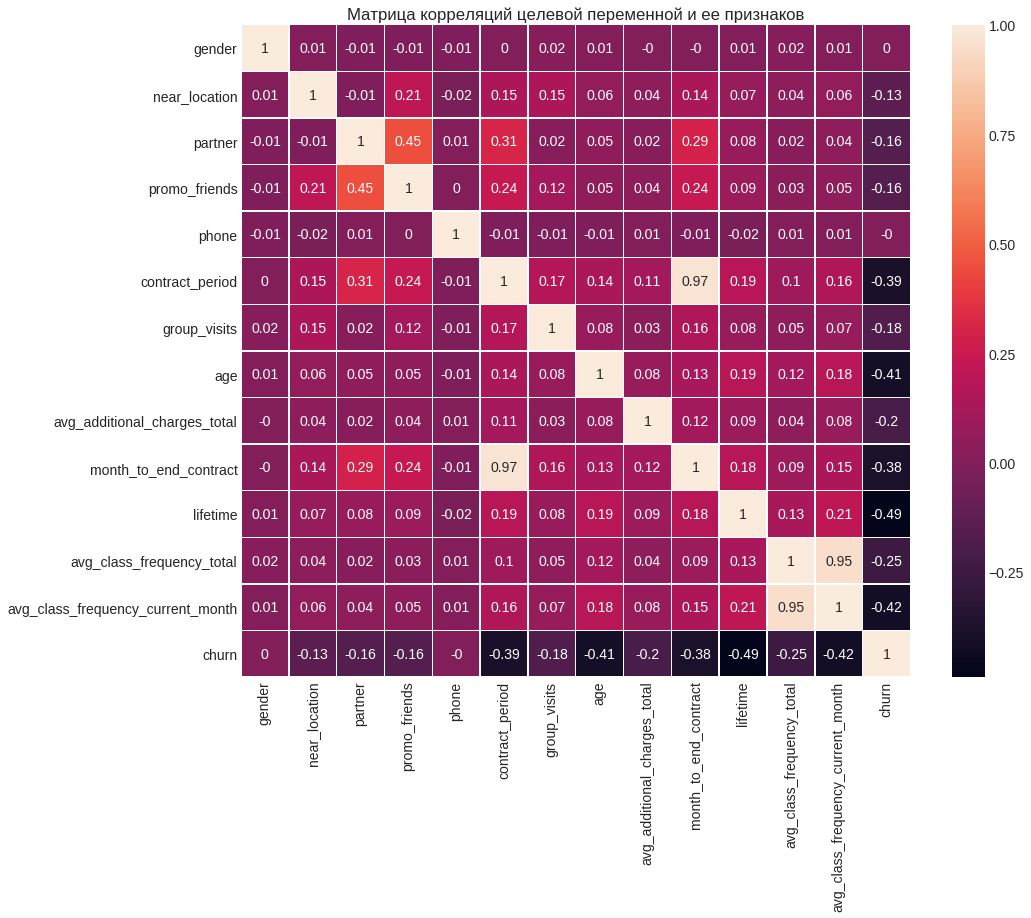

In [16]:
# построим матрицу корреляций целевой переменной и ее признаков
corr_m = df.corr().round(2)
fig, ax = plt.subplots(figsize = (15,12))
plt.title('Матрица корреляций целевой переменной и ее признаков')
sns.heatmap(corr_m, linewidths = 0.5, annot = True)
plt.show()

Исходя из матрицы корреляции, отсутствуют признаки, которые сильно коррелируют с целевой переменной, что говорит об отсутствии значительного их влияния на нее. В то же время между длительностью текущего действующего абонемента и сроком до его окончания, а также между средней частотой посещений в неделю за все время с начала действия абонемента и за предыдущий месяц имеется очень сильная корреляция (признаки являются взаимозависимыми). Для того, чтобы не допустить "переобучения" модели необходимо удалить по одному взаимозависимому признаку.

In [17]:
# удалим по одному взаимозависимому признаку
df = df.drop(['month_to_end_contract',
              'avg_class_frequency_total'], axis=1)
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'lifetime',
       'avg_class_frequency_current_month', 'churn'],
      dtype='object')

### Вывод

В имеющейся информации среди клиентов:  
- мужчин и женщин примерно равное количество;  
- почти 85% проживают или работают в районе нахождения фитнес-центра;  
- почти половина являются сотрудниками компании-партнёра клуба;  
- около 30% использовали промо-код от знакомых при оплате первого абонемента;  
- более 90% указали контактный телефон;  
- около 40% посещали групповые занятия.  

Средний возраст клиентов - около 29 лет, среднее время с момента их первого обращения в фитнес-центр - 3,7 месяцев, средняя длительность текущего действующего абонемента - 4,7 месяцев (в то же время у более половины клиентов длительность действующего абонемента всего 1 месяц), средний срок до окончания текущего действующего абонемента - 4,3 месяца.     

В среднем каждый клиент за все время с начала действия абонемента посещал фитнес-центр около 1,9 раз в неделю, а за предыдущий месяц - около 1,8 раз в неделю. В среднем каждый клиент израсходовал на другие услуги фитнес-центра около 147 рублей.  

Отток клиентов в текущем месяце составил 26,5%.  

Группы оставшихся и ушедших клиентов не оличаются только по полу и наличию контактного телефона. По остальным признакам средние показатели у оставшихся клиентов выше, чем у ушедших, по некоторым значительно. Так, например, доля клиентов, использовавших промо-код от знакомых при оплате первого абонемента, а также посещавших групповые занятия, в 2 раза больше у оставшихся клиентов, чем у ушедших. Длительность текущего действующего абонемента у оставшихся клиентов в 3 раза выше, а время с момента первого обращения в фитнес-центр почти в 5 раз (ушедшие клиенты в среднем пользуются фитнес-центром меньше 1 месяца). Кроме того, у ушедших клиентов меньшая средняя частота посещений фитнес-центра, они меньше расходуют деньги на другие услуги. Средний возраст у ушедших клиентов по сравнению с оставшимися ниже на 3 года.  

Распределения возраста, времени в месяцах с момента первого обращения в фитнес-центр, средней частоты посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, средней суммарной выручки от других услуг фитнес-центра скошены вправо (имеются выбросы). Перед построением модели для обработки выбросов значения, превышающие 95-й перцентиль, были заменены на значения, ему соответствующие. После удаления выбросов стандартные отклонения немного уменьшились.  

Признаков, которые сильно коррелируют с целевой переменной, нет, что говорит об отсутствии значительного их влияния на нее. В то же время между длительностью текущего действующего абонемента и сроком до его окончания, а также между средней частотой посещений в неделю за все время с начала действия абонемента и за предыдущий месяц имеется очень сильная корреляция (признаки являются взаимозависимыми). Для того, чтобы не допустить "переобучения" модели по одному взаимозависимому признаку были удалены.

### Модель прогнозирования оттока клиентов 
<a name="model"></a>

In [18]:
# разделим данные на целевую переменную и ее признаки 
x = df.drop('churn', axis = 1)
y = df['churn']

Разделим данные на обучащую и валидационную выборки в соотношении 80 к 20, то есть на 80% будем обучать модель, а на 20% - ее проверять.

In [19]:
# разделим данные на обучающую и валидационную выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)
print(f'Размер обучающей выбрки: {x_train.shape}')
print(f'Размер валидационной выбрки: {x_test.shape}')

Размер обучающей выбрки: (3200, 11)
Размер валидационной выбрки: (800, 11)


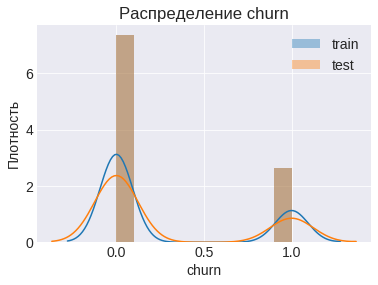

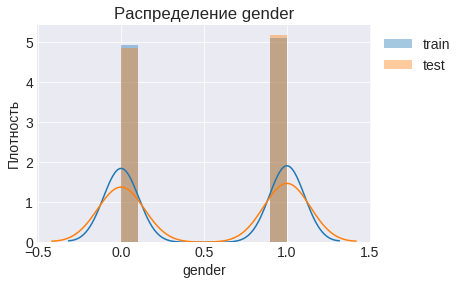

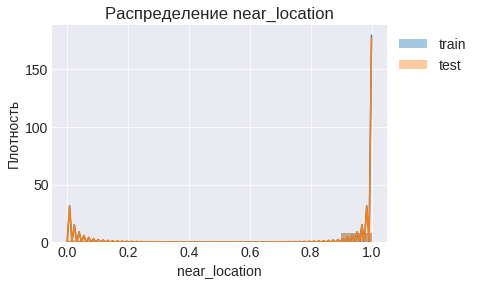

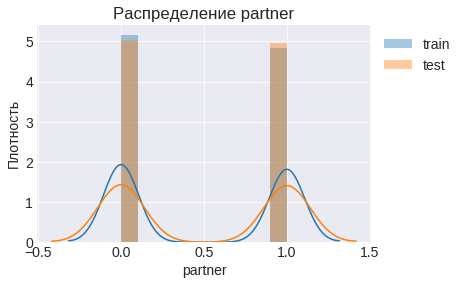

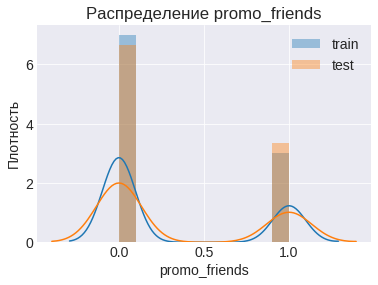

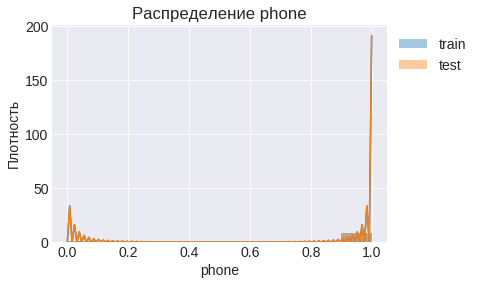

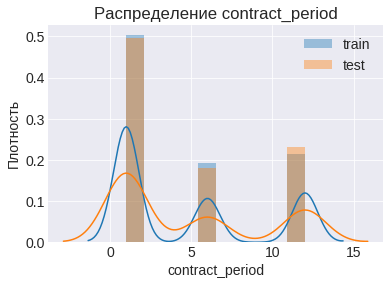

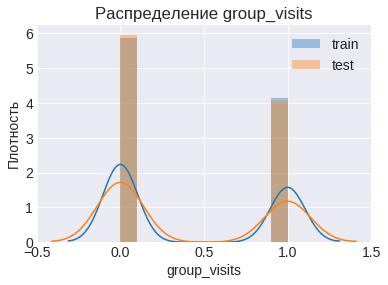

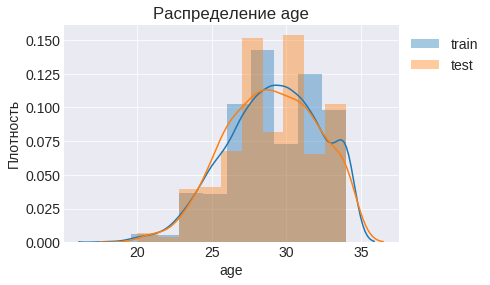

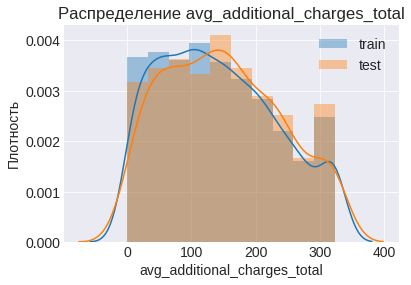

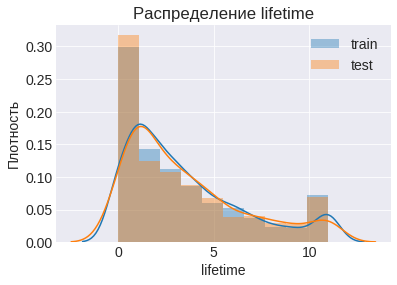

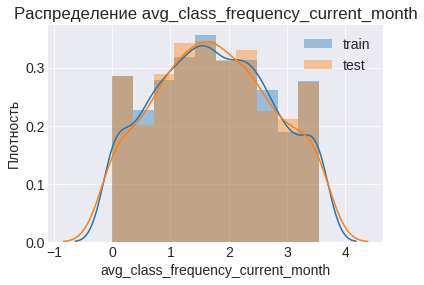

In [20]:
# построим столбчатые гистограммы и распределения целевой переменной и ее признаков
# на обучающей и валидационной выборках
fig, ax = plt.subplots()
plt.title('Распределение churn')
sns.distplot(y_train,
             bins = 10,
             label = 'train')
sns.distplot(y_test,
             bins = 10,
             label = 'test')
plt.xlabel('churn')
plt.ylabel('Плотность')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()
for column in x_train.columns:
    plt.title('Распределение ' + column)
    sns.distplot(x_train[column],
                 bins = 10,
                 label = 'train')
    sns.distplot(x_test[column],
                 bins = 10,
                 label = 'test')
    plt.xlabel(column)
    plt.ylabel('Плотность')
    plt.legend(bbox_to_anchor = (1, 1))
    plt.show()

Исходя из построенных графиков, распределения целевой переменной и ее признаков на обучающей и валидационной выборках похожи, следовательно модель, обученная на train-выборке, сможет работать и на тестовой.

In [21]:
# посчитаем средние арифметические и стандартные отклонения признаков по обучающей выборке
def print_mean_std(data, sample_name):
    print(f'Средние по {sample_name} выборке')
    print()
    print(np.mean(data))
    print()
    print(f'Стандартные отклонения по {sample_name} выборке')
    print()
    print(np.std(data))
    print()
print_mean_std(x_train, 'обучающей')

Средние по обучающей выборке

gender                                 0.508750
near_location                          0.847812
partner                                0.484375
promo_friends                          0.301563
phone                                  0.903125
contract_period                        4.651875
group_visits                           0.413750
age                                   29.117812
avg_additional_charges_total         143.132068
lifetime                               3.523438
avg_class_frequency_current_month      1.744944
dtype: float64

Стандартные отклонения по обучающей выборке

gender                                0.499923
near_location                         0.359203
partner                               0.499756
promo_friends                         0.458936
phone                                 0.295787
contract_period                       4.529424
group_visits                          0.492505
age                                   3.109893
avg_a

Диапазоны значений признаков различаются, в связи с чем перед построением моделей их необходимо привести к единому масштабу способом стандартизации.

In [22]:
# проведем стандартизацию признаков 
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.transform(x_test)

In [23]:
# посчитаем средние арифметические и стандартные отклонения признаков
# по стандартизированным обучающей и валидационной выборкам
print_mean_std(pd.DataFrame(x_train_st, columns = x_train.columns), 'стандартизированной обучающей')
print_mean_std(pd.DataFrame(x_test_st, columns = x_test.columns), 'стандартизированной тестовой')

Средние по стандартизированной обучающей выборке

gender                              -1.745826e-16
near_location                        7.951972e-17
partner                             -4.683753e-16
promo_friends                       -1.790235e-16
phone                               -1.196231e-15
contract_period                      7.663661e-16
group_visits                        -8.680556e-17
age                                  2.899764e-16
avg_additional_charges_total        -2.289835e-18
lifetime                            -1.689621e-17
avg_class_frequency_current_month    1.360023e-17
dtype: float64

Стандартные отклонения по стандартизированной обучающей выборке

gender                               1.0
near_location                        1.0
partner                              1.0
promo_friends                        1.0
phone                                1.0
contract_period                      1.0
group_visits                         1.0
age                             

После стандартизации у значений признаков на обучающей выборке средние арифметические стали равны 0, а стандартные отклонения - 1. В то же время на тестовой выборке средние значения не совсем 0, а отклонения не совсем 1, что связано с тем, что распределения признаков на валидации немного поменялись, но не критично. 

Проведем обучение моделей двумя способами: логистической регрессией и случайным лесом.

In [24]:
# обучим модель логистической регрессией
model_lr = LogisticRegression(random_state = 0)
model_lr.fit(x_train_st, y_train)
predictions_lr = model_lr.predict(x_test_st)
probabilities_lr = model_lr.predict_proba(x_test_st)[:,1]

In [25]:
# обучим модель случайным лесом
model_rf = RandomForestClassifier(random_state = 0)
model_rf.fit(x_train_st, y_train)
predictions_rf = model_rf.predict(x_test_st)
probabilities_rf = model_rf.predict_proba(x_test_st)[:,1]

Рассчитаем метрики классификации на основе значений прогнозного класса: "Accuracy" (доля правильных ответов), "Precision" (точность), "Recall" (полнота), "F1_score" (сводная метрика) и "ROC_AUC" (метрика оценки качества модели классификации).

In [26]:
# оценим метрики для обеих моделей
def print_metrics(y_true, y_pred, y_proba, model):
    print('Метрики для модели ' + model)
    print()
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1_score: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))
    print()
print_metrics(y_test, predictions_lr, probabilities_lr, '"логистическая регрессия"')
print_metrics(y_test, predictions_rf, probabilities_rf, '"случайный лес"')

Метрики для модели "логистическая регрессия"

	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.84
	F1_score: 0.85
	ROC_AUC: 0.97

Метрики для модели "случайный лес"

	Accuracy: 0.90
	Precision: 0.85
	Recall: 0.75
	F1_score: 0.80
	ROC_AUC: 0.95



Модель логистической регрессии для прогнозирования оттока клиентов в фитнес-центре подходит больше - у нее лучше все рассчитанные метрики. Доля правильных ответов у этой модели - 92%, точность - 85%, полнота - 84%. Значение метрики оценки качества классификатора 0,97 весьма высокое, что свидетельствует о хорошем качестве прогнозирования. 

Определим степень влияния каждого признака на финальный прогноз целевой пременной.

In [27]:
# посчитаем веса для каждого признака
features = pd.DataFrame({'feature': df.drop('churn', axis = 1).columns,
                         'coeff': model_lr.coef_[0]})
features['coeff_abs'] = features['coeff'].abs()
features.sort_values(by = 'coeff_abs',
                     ascending = False)\
        .reset_index(drop = True)

,feature,coeff,coeff_abs
0,lifetime,-3.024063,3.024063
1,contract_period,-1.385163,1.385163
2,avg_class_frequency_current_month,-1.227577,1.227577
3,age,-1.125909,1.125909
4,avg_additional_charges_total,-0.540863,0.540863
5,group_visits,-0.380610,0.380610
6,promo_friends,-0.149624,0.149624
7,phone,-0.071775,0.071775
8,near_location,-0.064328,0.064328
9,partner,-0.057837,0.057837


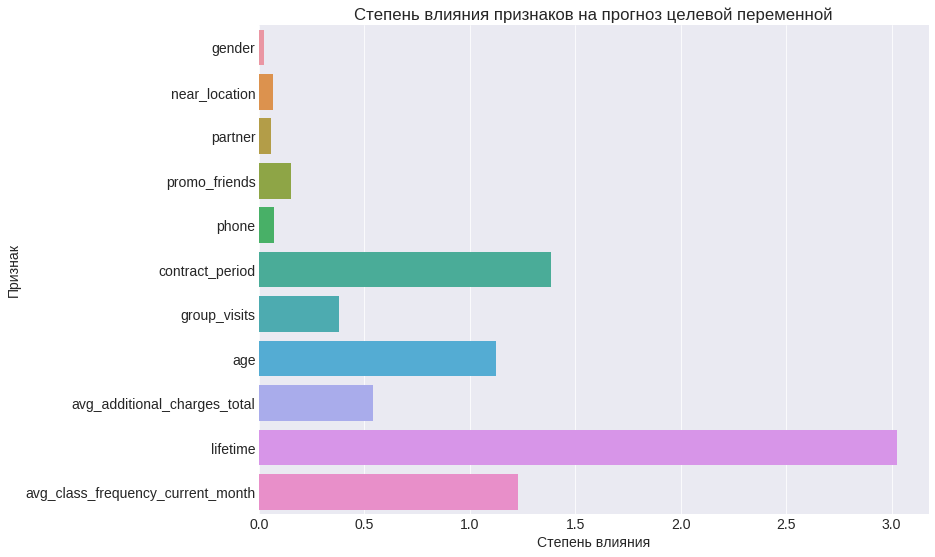

In [28]:
# построим график степени влияния признаков на прогноз целевой переменной
fig, ax = plt.subplots(figsize = (12,9))
plt.title('Степень влияния признаков на прогноз целевой переменной')
sns.barplot(data = features,
            x = 'coeff_abs',
            y = 'feature')
plt.xlabel('Степень влияния')
plt.ylabel('Признак')
plt.show()

Практически все полученные коэффициенты отрицательные, что свидетельствует об обратной связи признаков на отток клиентов из фитнес-центра. Наибольший вес по модулю - у времени с момента первого обращения в фитнес-центр. Скорее всего, чем клиенты дольше пользуются фитнес-центром, тем большая вероятность, что они не уйдут в отток. Высокие показатели влияния также у длительности текущего действующего абонемента, средней частоты посещений в неделю за предыдущий месяц и возраста клиента. Наименьшее влияние на прогноз оттока клиентов оказывают его пол, принадлежность к компании-партнеру клуба, факт проживания или работы в районе фитнес-центра, наличие контактного телефона. 

### Вывод

Данные были разделены на обучащую и валидационную выборки в соотношении 80 к 20. Распределения целевой переменной и ее признаков на обучающей и валидационной выборках похожи, следовательно модель, обученная на train-выборке, сможет работать и на тестовой.  

Диапазоны значений признаков различаются, в связи с чем перед построением моделей они были приведены к единому масштабу способом стандартизации. После стандартизации у значений признаков на обучающей выборке средние арифметические стали равны 0, а стандартные отклонения - 1. В то же время на тестовой выборке средние значения не совсем 0, а отклонения не совсем 1, что связано с тем, что распределения признаков на валидации немного поменялись, но не критично.  

Из двух построенных моделей модель логистической регрессии для прогнозирования оттока клиентов в фитнес-центре подходит больше - у нее лучше все рассчитанные метрики. Доля правильных ответов у этой модели - 92%, точность - 85%, полнота - 84%. Значение метрики оценки качества классификатора 0,97 весьма высокое, что свидетельствует о хорошем качестве прогнозирования. 

Практически все полученные коэффициенты степени влияния признаков на прогноз целевой пременной отрицательные, что свидетельствует об обратной связи признаков на отток клиентов из фитнес-центра. Наибольший вес по модулю - у времени с момента первого обращения в фитнес-центр. Скорее всего, чем клиенты дольше пользуются фитнес-центром, тем большая вероятность, что они не уйдут в отток. Высокие показатели влияния также у длительности текущего действующего абонемента, средней частоты посещений в неделю за предыдущий месяц и возраста клиента. Наименьшее влияние на прогноз оттока клиентов оказывают его пол, принадлежность к компании-партнеру клуба, факт проживания или работы в районе фитнес-центра, наличие контактного телефона.  

### Кластеризация клиентов 
<a name="clustering"></a>

Перед проведением кластеризации клиентов стандартизируем данные.

In [29]:
# проведем стандартизацию данных 
x_sc = scaler.fit_transform(x)

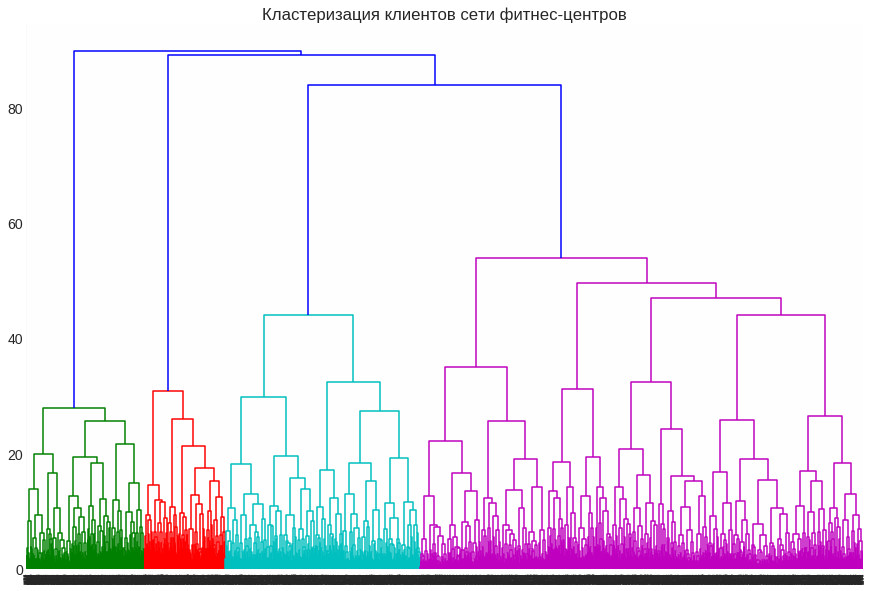

In [30]:
# построим матрицу расстояний и нарисуем дендрограмму
links = hierarchy.linkage(x_sc, 'ward')
plt.figure(figsize = (15, 10))
plt.title('Кластеризация клиентов сети фитнес-центров')
hierarchy.dendrogram(links)
plt.show()

Исходя из построенной дендрограммы, можно предположить о наличии 4 кластеров клиентов. В то же время, для решения учебной задачи разделим клиентов на 5 кластеров.

Проведем обучение модели кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [31]:
# проведем обучение модели и спрогнозируем кластеры
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(x_sc)

In [32]:
# добавим в таблицу столбец с полученными кластерами клиентов
df['cluster'] = labels
df['cluster'] = df['cluster'].replace(4, 5)\
                             .replace(3, 4)\
                             .replace(2, 3)\
                             .replace(1, 2)\
                             .replace(0, 1)
df.groupby('cluster')['churn'].count()

cluster
1     559
2     974
3    1012
4    1069
5     386
Name: churn, dtype: int64

Клиенты распределены по 5 кластерам, причем в разные кластеры попало разное количество клиентов - от 386 до 1080.

In [33]:
# посмотрим на средние значения признаков для кластеров
df.drop(['churn'], axis = 1).groupby('cluster').mean().T

cluster,1,2,3,4,5
gender,0.497317,0.502053,0.482213,0.546305,0.523316
near_location,0.000000,0.994867,1.000000,0.998129,0.862694
partner,0.486583,0.886037,0.228261,0.373246,0.471503
promo_friends,0.076923,1.000000,0.092885,0.004677,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.010733,6.989733,2.051383,5.906455,4.777202
group_visits,0.234347,0.531828,0.288538,0.507951,0.427461
age,28.654741,29.573922,27.470356,30.402245,29.199482
avg_additional_charges_total,134.853834,153.143556,114.610663,170.861962,142.107411
lifetime,2.881932,4.202259,1.711462,4.900842,3.709845


Характеристика клиентов из первого кластера:  
- представителей одного пола немного больше, чем другого;    
- 86% проживают или работают в районе нахождения фитнес-центра;    
- почти половина являются сотрудниками компании-партнёра клуба;    
- 30% использовали промо-код от знакомых при оплате первого абонемента;    
- контактный телефон никто не указал;  
- средняя длительность текущего действующего абонемента 4,8 месяцев;  
- 43% посещали групповые занятия;  
- средний возраст 29 лет;  
- в среднем каждый клиент израсходовал на другие услуги фитнес-центра 142 рубля;  
- среднее время с момента первого обращения в фитнес-центр 3,7 месяцев;    
- в среднем каждый клиент за предыдущий месяц посещал фитнес-центр 1,7 раз в неделю.  

Характеристика клиентов из второго кластера:  
- мужчин и женщин примерно равное количество;   
- никто не проживает или работает в районе нахождения фитнес-центра;    
- почти половина являются сотрудниками компании-партнёра клуба;    
- 8% использовали промо-код от знакомых при оплате первого абонемента;    
- контактный телефон указан всеми;  
- средняя длительность текущего действующего абонемента 2 месяца;  
- 24% посещали групповые занятия;  
- средний возраст 29 лет;  
- в среднем каждый клиент израсходовал на другие услуги фитнес-центра 135 рублей;  
- среднее время с момента первого обращения в фитнес-центр 2,9 месяцев;    
- в среднем каждый клиент за предыдущий месяц посещал фитнес-центр 1,6 раз в неделю.  

Характеристика клиентов из третьего кластера:  
- мужчин и женщин примерно равное количество;   
- все проживают или работают в районе нахождения фитнес-центра;    
- 31% являются сотрудниками компании-партнёра клуба;    
- 16% использовали промо-код от знакомых при оплате первого абонемента;    
- контактный телефон указан всеми;  
- средняя длительность текущего действующего абонемента 3 месяца;  
- 27% посещали групповые занятия;  
- средний возраст 27 лет;  
- в среднем каждый клиент израсходовал на другие услуги фитнес-центра 115 рублей;  
- среднее время с момента первого обращения в фитнес-центр 1,5 месяцев;    
- в среднем каждый клиент за предыдущий месяц посещал фитнес-центр 1,1 раз в неделю.  

Характеристика клиентов из четвертого кластера:  
- мужчин и женщин примерно равное количество;   
- почти все проживают или работают в районе нахождения фитнес-центра;    
- 96% являются сотрудниками компании-партнёра клуба;    
- 79% использовали промо-код от знакомых при оплате первого абонемента;    
- контактный телефон указан всеми;  
- средняя длительность текущего действующего абонемента 8,5 месяцев;  
- около половины посещали групповые занятия;  
- средний возраст 30 лет;  
- в среднем каждый клиент израсходовал на другие услуги фитнес-центра 155 рублей;  
- среднее время с момента первого обращения в фитнес-центр 4,3 месяцев;    
- в среднем каждый клиент за предыдущий месяц посещал фитнес-центр 2 раза в неделю.  

Характеристика клиентов из пятого кластера:  
- представителей одного пола немного больше, чем другого;    
- все проживают или работают в районе нахождения фитнес-центра;    
- 16% являются сотрудниками компании-партнёра клуба;    
- 6% использовали промо-код от знакомых при оплате первого абонемента;    
- контактный телефон указан всеми;  
- средняя длительность текущего действующего абонемента 4,1 месяцев;  
- около половины посещали групповые занятия;  
- средний возраст 30 лет;  
- в среднем каждый клиент израсходовал на другие услуги фитнес-центра 169 рублей;  
- среднее время с момента первого обращения в фитнес-центр 5 месяцев;    
- в среднем каждый клиент за предыдущий месяц посещал фитнес-центр 2,3 раз в неделю.  

Проанализировав средние значения признаков, можно предположить, что лучшие показатели, как правило, у четвертого и пятого кластеров клиентов.

Для оценки результатов кластеризации рассчитаем метрику силуэта "Silhouette score" (насколько объект своего кластера похож на свой кластер больше, чем на чужой).

In [34]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(x_sc, labels)))

Silhouette_score: 0.14


Значение метрики оказалось совсем невысоким, что свидетельствует об отсутствии ярко выраженного разделения клиентов.

Для анализа распределения признаков по кластерам построим столбчатые диаграммы для логических и дискретных переменных и "ящики с усами" для непрерывных переменных.

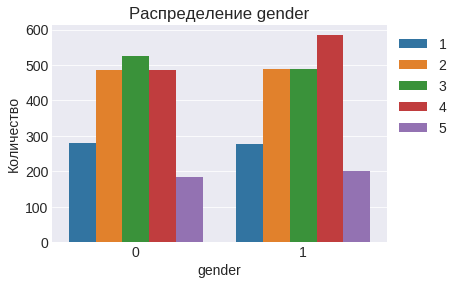

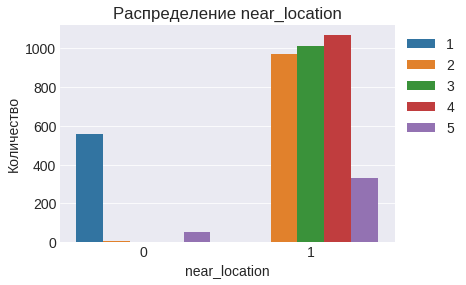

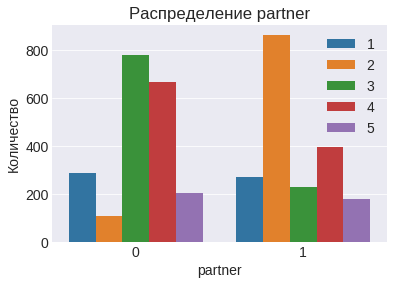

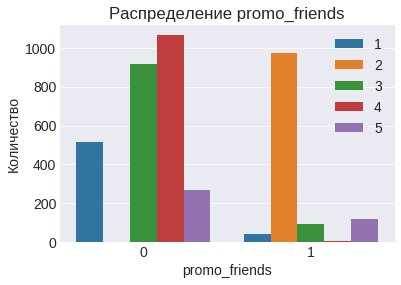

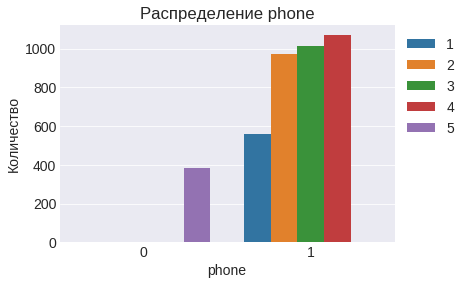

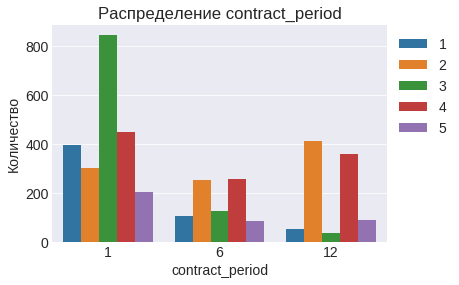

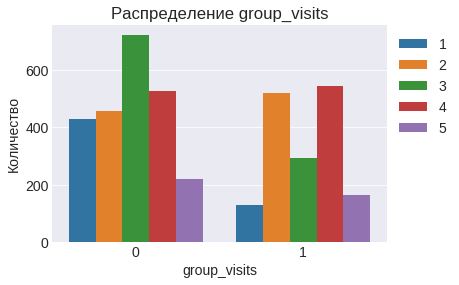

In [35]:
# построим столбчатые диаграммы по кластерам
discrete_columns = ['gender',
                   'near_location',
                   'partner',
                   'promo_friends',
                   'phone',
                   'contract_period',
                   'group_visits']
fig, ax = plt.subplots()
for column in discrete_columns:
    plt.title('Распределение ' + column)
    sns.countplot(data = df,
                  x = column,
                  hue = 'cluster')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.legend(bbox_to_anchor = (1, 1))
    plt.show()

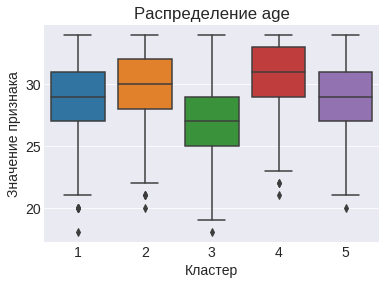

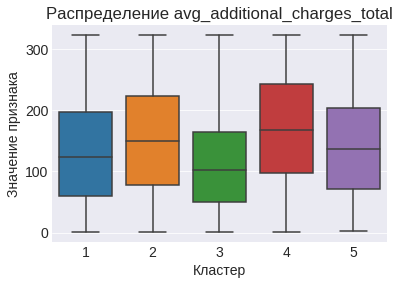

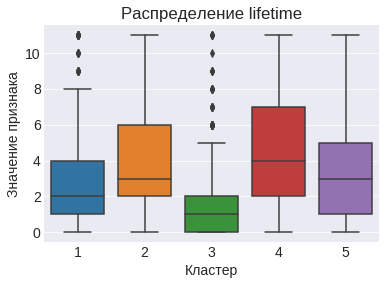

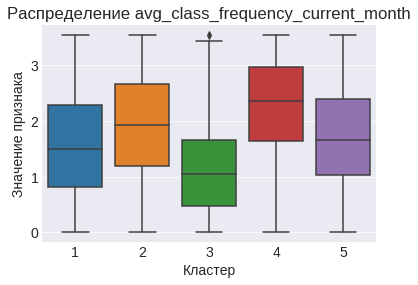

In [36]:
# построим "ящики с усами" по кластерам
continuous_columns = ['age',
                      'avg_additional_charges_total',
                      'lifetime',
                      'avg_class_frequency_current_month']
fig, ax = plt.subplots()
for column in continuous_columns:
    plt.title('Распределение ' + column)
    sns.boxplot(data = df,
                x = 'cluster',
                y = column)
    plt.xlabel('Кластер')
    plt.ylabel('Значение признака')
    plt.show()

Исходя из построенных графиков распределения, лучшие показатели, как правило, у четвертого и пятого кластеров клиентов, худшие - у третьего.

In [37]:
# посчитаем долю оттока клиентов для каждого кластера
cluster_churn_mean = df.groupby('cluster')['churn']\
                       .mean()\
                       .reset_index()\
                       .sort_values(by = 'churn',
                                    ascending = False)\
                       .reset_index(drop = True)
cluster_churn_mean

,cluster,churn
0,3,0.603755
1,1,0.402504
2,5,0.266839
3,2,0.102669
4,4,0.020580


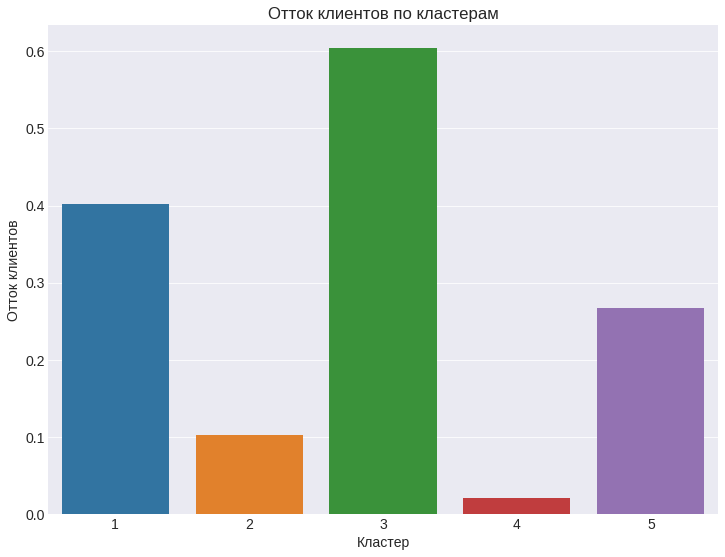

In [38]:
# построим график оттока клиентов по кластерам
fig, ax = plt.subplots(figsize = (12,9))
plt.title('Отток клиентов по кластерам')
sns.barplot(data = cluster_churn_mean,
            x = 'cluster',
            y = 'churn')
plt.xlabel('Кластер')
plt.ylabel('Отток клиентов')
plt.show()

У клиентов из третьего кластера самая высокая доля оттока клиентов - более 65%, самая низкая - из пятого - всего 3,5%, и четвертого - 5,3% - кластеров.

### Вывод

Перед проведением кластеризации клиентов данные были стандартизированы. Исходя из построенной дендрограммы, можно предположить о наличии 4 кластеров клиентов. В то же время, для решения учебной задачи клиенты были распределены по 5 кластерам, причем в разные кластеры попало разное количество клиентов - от 386 до 1080.  

Характеристика клиентов из первого кластера:  
- представителей одного пола немного больше, чем другого;    
- 86% проживают или работают в районе нахождения фитнес-центра;    
- почти половина являются сотрудниками компании-партнёра клуба;    
- 30% использовали промо-код от знакомых при оплате первого абонемента;    
- контактный телефон никто не указал;  
- средняя длительность текущего действующего абонемента 4,8 месяцев;  
- 43% посещали групповые занятия;  
- средний возраст 29 лет;  
- в среднем каждый клиент израсходовал на другие услуги фитнес-центра 142 рубля;  
- среднее время с момента первого обращения в фитнес-центр 3,7 месяцев;    
- в среднем каждый клиент за предыдущий месяц посещал фитнес-центр 1,7 раз в неделю.  

Характеристика клиентов из второго кластера:  
- мужчин и женщин примерно равное количество;   
- никто не проживает или работает в районе нахождения фитнес-центра;    
- почти половина являются сотрудниками компании-партнёра клуба;    
- 8% использовали промо-код от знакомых при оплате первого абонемента;    
- контактный телефон указан всеми;  
- средняя длительность текущего действующего абонемента 2 месяца;  
- 24% посещали групповые занятия;  
- средний возраст 29 лет;  
- в среднем каждый клиент израсходовал на другие услуги фитнес-центра 135 рублей;  
- среднее время с момента первого обращения в фитнес-центр 2,9 месяцев;    
- в среднем каждый клиент за предыдущий месяц посещал фитнес-центр 1,6 раз в неделю.  

Характеристика клиентов из третьего кластера:  
- мужчин и женщин примерно равное количество;   
- все проживают или работают в районе нахождения фитнес-центра;    
- 31% являются сотрудниками компании-партнёра клуба;    
- 16% использовали промо-код от знакомых при оплате первого абонемента;    
- контактный телефон указан всеми;  
- средняя длительность текущего действующего абонемента 3 месяца;  
- 27% посещали групповые занятия;  
- средний возраст 27 лет;  
- в среднем каждый клиент израсходовал на другие услуги фитнес-центра 115 рублей;  
- среднее время с момента первого обращения в фитнес-центр 1,5 месяцев;    
- в среднем каждый клиент за предыдущий месяц посещал фитнес-центр 1,1 раз в неделю.  

Характеристика клиентов из четвертого кластера:  
- мужчин и женщин примерно равное количество;   
- почти все проживают или работают в районе нахождения фитнес-центра;    
- 96% являются сотрудниками компании-партнёра клуба;    
- 79% использовали промо-код от знакомых при оплате первого абонемента;    
- контактный телефон указан всеми;  
- средняя длительность текущего действующего абонемента 8,5 месяцев;  
- около половины посещали групповые занятия;  
- средний возраст 30 лет;  
- в среднем каждый клиент израсходовал на другие услуги фитнес-центра 155 рублей;  
- среднее время с момента первого обращения в фитнес-центр 4,3 месяцев;    
- в среднем каждый клиент за предыдущий месяц посещал фитнес-центр 2 раза в неделю.  

Характеристика клиентов из пятого кластера:  
- представителей одного пола немного больше, чем другого;    
- все проживают или работают в районе нахождения фитнес-центра;    
- 16% являются сотрудниками компании-партнёра клуба;    
- 6% использовали промо-код от знакомых при оплате первого абонемента;    
- контактный телефон указан всеми;  
- средняя длительность текущего действующего абонемента 4,1 месяцев;  
- около половины посещали групповые занятия;  
- средний возраст 30 лет;  
- в среднем каждый клиент израсходовал на другие услуги фитнес-центра 169 рублей;  
- среднее время с момента первого обращения в фитнес-центр 5 месяцев;    
- в среднем каждый клиент за предыдущий месяц посещал фитнес-центр 2,3 раз в неделю.  

Проанализировав средние значения признаков, а также построенные графики распределения, можно предположить, что лучшие показатели, как правило, у четвертого и пятого кластеров клиентов, худшие - у третьего.  

Для оценки результатов кластеризации была рассчитана метрика силуэта "Silhouette score". Значение метрики оказалось совсем невысоким, что свидетельствует об отсутствии ярко выраженного разделения клиентов.  

Самая высокая доля оттока оказалась у клиентов из третьего кластера - более 65%, самая низкая - из пятого - всего 3,5%, и четвертого - 5,3% - кластеров.

### Общий вывод
<a name="conclusion"></a>

Общая характеристика клиентов по всей имеющейся информации:   
- мужчин и женщин примерно равное количество;  
- почти 85% проживают или работают в районе нахождения фитнес-центра;  
- почти половина являются сотрудниками компании-партнёра клуба;  
- около 30% использовали промо-код от знакомых при оплате первого абонемента;  
- более 90% указали контактный телефон;  
- средняя длительность текущего действующего абонемента 4,7 месяцев;  
- около 40% посещали групповые занятия;  
- средний возраст около 29 лет;  
- в среднем каждый клиент израсходовал на другие услуги фитнес-центра около 147 рублей;  
- среднее время с момента первого обращения в фитнес-центр 3,7 месяцев;    
- в среднем каждый клиент за предыдущий месяц посещал фитнес-центр 1,8 раз в неделю.  

Отток клиентов в текущем месяце составил 26,5%.  

Группы оставшихся и ушедших клиентов не оличаются только по полу и наличию контактного телефона. По остальным признакам средние показатели у оставшихся клиентов выше, чем у ушедших, по некоторым значительно. Так, например, доля клиентов, использовавших промо-код от знакомых при оплате первого абонемента, а также посещавших групповые занятия, в 2 раза больше у оставшихся клиентов, чем у ушедших. Длительность текущего действующего абонемента у оставшихся клиентов в 3 раза выше, а время с момента первого обращения в фитнес-центр почти в 5 раз (ушедшие клиенты в среднем пользуются фитнес-центром меньше 1 месяца). Кроме того, у ушедших клиентов меньшая средняя частота посещений фитнес-центра, они меньше расходуют деньги на другие услуги. Средний возраст у ушедших клиентов по сравнению с оставшимися ниже на 3 года.  

Из двух построенных моделей модель логистической регрессии для прогнозирования оттока клиентов в фитнес-центре подходит больше - у нее лучше все рассчитанные метрики. Доля правильных ответов у этой модели - 92%, точность - 85%, полнота - 84%. Значение метрики оценки качества классификатора 0,97 весьма высокое, что свидетельствует о хорошем качестве прогнозирования.  

Практически все полученные коэффициенты степени влияния признаков на прогноз целевой пременной отрицательные, что свидетельствует об обратной связи признаков на отток клиентов из фитнес-центра. Наибольший вес по модулю - у времени с момента первого обращения в фитнес-центр. Скорее всего, чем клиенты дольше пользуются фитнес-центром, тем большая вероятность, что они не уйдут в отток. Высокие показатели влияния также у длительности текущего действующего абонемента, средней частоты посещений в неделю за предыдущий месяц и возраста клиента. Наименьшее влияние на прогноз оттока клиентов оказывают его пол, принадлежность к компании-партнеру клуба, факт проживания или работы в районе фитнес-центра, наличие контактного телефона.  

При проведении кластеризации клиентов значение метрики силуэта "Silhouette score" оказалось совсем невысоким, что свидетельствует об отсутствии ярко выраженного разделения клиентов. Вместе с тем, самая высокая доля оттока оказалась у клиентов из третьего кластера - более 65%, самая низкая - из пятого - всего 3,5%, и четвертого - 5,3% - кластеров. 

Характеристика клиентов из пятого кластера:  
- представителей одного пола немного больше, чем другого;    
- все проживают или работают в районе нахождения фитнес-центра;    
- 16% являются сотрудниками компании-партнёра клуба;    
- 6% использовали промо-код от знакомых при оплате первого абонемента;    
- контактный телефон указан всеми;  
- средняя длительность текущего действующего абонемента 4,1 месяцев;  
- около половины посещали групповые занятия;  
- средний возраст 30 лет;  
- в среднем каждый клиент израсходовал на другие услуги фитнес-центра 169 рублей;  
- среднее время с момента первого обращения в фитнес-центр 5 месяцев;    
- в среднем каждый клиент за предыдущий месяц посещал фитнес-центр 2,3 раз в неделю.  

Характеристика клиентов из четвертого кластера:  
- мужчин и женщин примерно равное количество;   
- почти все проживают или работают в районе нахождения фитнес-центра;    
- 96% являются сотрудниками компании-партнёра клуба;    
- 79% использовали промо-код от знакомых при оплате первого абонемента;    
- контактный телефон указан всеми;  
- средняя длительность текущего действующего абонемента 8,5 месяцев;  
- около половины посещали групповые занятия;  
- средний возраст 30 лет;  
- в среднем каждый клиент израсходовал на другие услуги фитнес-центра 155 рублей;  
- среднее время с момента первого обращения в фитнес-центр 4,3 месяцев;    
- в среднем каждый клиент за предыдущий месяц посещал фитнес-центр 2 раза в неделю.  

### Рекомендации
<a name="recommendations"></a>

Для повышения качества работы с клиентами фитнес-центра и уменьшения их оттока рекомендуется:  
1. Продвигать продажу абонементов более продолжительного срока (9 или 12 месяцев) возможно путем установления более выгодных цен на длительные абонементы, скидок при продлении длительных абонементов либо скидок на другие услуги фитнес-центра при приобретении длительных абонементов, поскольку чем продолжительнее абонемент, тем лояльнее клиент.  
2. Проводить мониторинг средней частоты посещений клиентами фитнес-центра, при выявлении снижения показателя предлагать им различные "бонусы" (скидки на продление абонемента, одно бесплатное занятие по новому направлению и т.п.).  
3. Уделить внимание более молодым клиентам, так как у них отток выше, возможно путем организации совместных групповых занятий клиентов разного пола.  
4. Рассмотреть целесообразность акции «приведи друга» и скидок сотрудникам компании-партнёра клуба, поскольку они практически не влияют на отток клиентов, а высвободившиеся средства направить на другие мероприятия.